In [4]:


# ============================================================
# 1. IMPORTS & GLOBAL SETTINGS
# ============================================================

import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from catboost import Pool, CatBoostRegressor

RANDOM_STATE = 42






In [5]:
import os
import pickle
import numpy as np

# MUST match app structure
PROJECT_ROOT = "/Users/abigailtubbs/Downloads/digital_twin"
MODEL_DIR = os.path.join(PROJECT_ROOT, "model")

os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# Shared artifact paths (TRAIN ↔ PREDICTOR CONTRACT)
# ------------------------------------------------------------
FEATURE_NAMES_PATH = os.path.join(MODEL_DIR, "FEATURE_NAMES.pkl")

print("MODEL_DIR:", MODEL_DIR)
print("FEATURE_NAMES_PATH:", FEATURE_NAMES_PATH)



MODEL_DIR: /Users/abigailtubbs/Downloads/digital_twin/model
FEATURE_NAMES_PATH: /Users/abigailtubbs/Downloads/digital_twin/model/FEATURE_NAMES.pkl


In [6]:
# ============================================================
# 2. LOAD RAW DATA
# ============================================================

RAW_DATA_PATH = "/Users/abigailtubbs/Desktop/Fall 2025/Dissertation F25/Harry/cleaned_dataset.xlsx"

df_raw = pd.read_excel(RAW_DATA_PATH)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (1290, 88)


,nct_id,age_age_continuous,race_american_indian_or_alaska_native,race_asian,race_black_or_african_american,race_more_than_one_race,race_native_hawaiian_or_other_pacific_islander,race_unknown_or_not_reported,race_white,gender_female,...,female_pct_calc,female_pct,baseline_female_pct,female_pdrr,female_score,sex_total_score,sex_rating,age_denom,age65_pct_calc,age65_pct
0,NCT04656132,61.13,0.0,5.0,6.0,2.0,0.0,1.0,45.0,30.0,...,0.508475,0.508475,0.504,1.008878,3,6,Good,59,0.000000,0.000000
1,NCT02707432,57.26,0.0,0.0,143.0,0.0,0.0,0.0,0.0,101.0,...,0.721429,0.721429,0.504,1.431406,3,5,Fair,140,0.342857,0.342857
2,NCT05384834,20.00,1.0,1.0,50.0,0.0,0.0,7.0,1.0,60.0,...,1.000000,1.000000,0.504,1.984127,3,3,Poor,60,0.000000,0.000000
3,NCT05838027,46.90,0.0,0.0,90.0,4.0,0.0,2.0,4.0,78.0,...,0.780000,0.780000,0.504,1.547619,3,4,Poor,100,0.000000,0.000000
4,NCT04574882,59.50,2.0,23.0,207.0,0.0,0.0,78.0,471.0,428.0,...,0.611429,0.611429,0.504,1.213152,3,5,Fair,700,0.000000,0.000000


In [7]:
# ============================================================
# 2B. CENTRALIZED CLEANING (FINAL, GEO-SAFE, FEATURE-NEUTRAL)
# ============================================================

def clean_missing(df):
    """
    Cleans raw trial fields:
      - parses age columns
      - creates missingness flags
      - normalizes NON-geographic categoricals
      - fills text fields

    IMPORTANT:
      • Does NOT create features
      • Does NOT modify geography
      • Safe to run exactly once
    """

    df = df.copy()

    # ----------------------------------------------
    # IDENTIFY AGE COLUMNS (DETERMINISTIC)
    # ----------------------------------------------
    min_age_candidates = [c for c in df.columns if c.lower() == "eligibility_min_age"]
    max_age_candidates = [c for c in df.columns if c.lower() == "eligibility_max_age"]

    if not min_age_candidates or not max_age_candidates:
        raise KeyError("Expected eligibility_min_age / eligibility_max_age columns")

    min_age_col = min_age_candidates[0]
    max_age_col = max_age_candidates[0]

    # ----------------------------------------------
    # PARSE AGE STRINGS → FLOAT
    # ----------------------------------------------
    def parse_age(x):
        if x is None or pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            return float(x)

        s = str(x)
        for word in ["Years", "Year", "years", "year", "yrs", "yr", "Yrs", "Y"]:
            s = s.replace(word, "")
        try:
            return float(s.strip())
        except ValueError:
            return np.nan

    df[min_age_col] = df[min_age_col].apply(parse_age)
    df[max_age_col] = df[max_age_col].apply(parse_age)

    # ----------------------------------------------
    # MISSINGNESS FLAGS (NOT FEATURES YET)
    # ----------------------------------------------
    df["min_age_missing"] = df[min_age_col].isna().astype(int)
    df["max_age_missing"] = df[max_age_col].isna().astype(int)

    # ----------------------------------------------
    # IMPUTE MEDIANS (TEMPORARY VALUES)
    # ----------------------------------------------
    df[min_age_col] = df[min_age_col].fillna(df[min_age_col].median())
    df[max_age_col] = df[max_age_col].fillna(df[max_age_col].median())

    # ----------------------------------------------
    # NON-GEOGRAPHIC CATEGORICAL CLEANING ONLY
    # ----------------------------------------------
    cat_cols = [
        "eligibility_sex", "sponsor", "collaborators",
        "phases", "funder_type", "study_type", "allocation",
        "intervention_model", "masking", "primary_purpose"
    ]

    for col in cat_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .replace({"nan": "Unknown", "None": "Unknown"})
                .fillna("Unknown")
            )

    # ----------------------------------------------
    # TEXT FIELDS
    # ----------------------------------------------
    text_cols = [
        "inclusion_text", "exclusion_text", "conditions_text",
        "interventions_text", "primary_outcome_text", "secondary_outcome_text"
    ]

    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna("")

    return df




In [8]:
# ============================================================
# 3. APPLY CLEANING PIPELINE
# ============================================================

df_clean = clean_missing(df_raw)

print("Cleaned shape:", df_clean.shape)
df_clean.head()




Cleaned shape: (1290, 90)


,nct_id,age_age_continuous,race_american_indian_or_alaska_native,race_asian,race_black_or_african_american,race_more_than_one_race,race_native_hawaiian_or_other_pacific_islander,race_unknown_or_not_reported,race_white,gender_female,...,baseline_female_pct,female_pdrr,female_score,sex_total_score,sex_rating,age_denom,age65_pct_calc,age65_pct,min_age_missing,max_age_missing
0,NCT04656132,61.13,0.0,5.0,6.0,2.0,0.0,1.0,45.0,30.0,...,0.504,1.008878,3,6,Good,59,0.000000,0.000000,0,1
1,NCT02707432,57.26,0.0,0.0,143.0,0.0,0.0,0.0,0.0,101.0,...,0.504,1.431406,3,5,Fair,140,0.342857,0.342857,0,1
2,NCT05384834,20.00,1.0,1.0,50.0,0.0,0.0,7.0,1.0,60.0,...,0.504,1.984127,3,3,Poor,60,0.000000,0.000000,0,1
3,NCT05838027,46.90,0.0,0.0,90.0,4.0,0.0,2.0,4.0,78.0,...,0.504,1.547619,3,4,Poor,100,0.000000,0.000000,0,1
4,NCT04574882,59.50,2.0,23.0,207.0,0.0,0.0,78.0,471.0,428.0,...,0.504,1.213152,3,5,Fair,700,0.000000,0.000000,0,0


In [9]:
# ============================================================
# ============================================================
# 4. GEOGRAPHIC FEATURE ENGINEERING (FINAL, U.S.-ONLY)
# ============================================================

import re

# ------------------------------------------------------------
# U.S. state → Census region map
# ------------------------------------------------------------
STATE_TO_REGION = {
    # Northeast
    "CT":"Northeast","ME":"Northeast","MA":"Northeast","NH":"Northeast",
    "RI":"Northeast","VT":"Northeast","NJ":"Northeast","NY":"Northeast","PA":"Northeast",
    # Midwest
    "IL":"Midwest","IN":"Midwest","MI":"Midwest","OH":"Midwest","WI":"Midwest",
    "IA":"Midwest","KS":"Midwest","MN":"Midwest","MO":"Midwest","NE":"Midwest","ND":"Midwest","SD":"Midwest",
    # South
    "DE":"South","FL":"South","GA":"South","MD":"South","NC":"South","SC":"South","VA":"South","DC":"South","WV":"South",
    "AL":"South","KY":"South","MS":"South","TN":"South","AR":"South","LA":"South","OK":"South","TX":"South",
    # West
    "AZ":"West","CO":"West","ID":"West","MT":"West","NV":"West","NM":"West","UT":"West","WY":"West",
    "AK":"West","CA":"West","HI":"West","OR":"West","WA":"West"
}

US_STATES = set(STATE_TO_REGION.keys())
STATE_PATTERN = r"\b(" + "|".join(US_STATES) + r")\b"

# ------------------------------------------------------------
# Parse US states from Locations text
# ------------------------------------------------------------
def extract_us_states(text):
    if not isinstance(text, str):
        return []
    return list(set(re.findall(STATE_PATTERN, text)))

# ------------------------------------------------------------
# Apply extraction
# ------------------------------------------------------------
df_clean["us_states"] = df_clean["Locations"].apply(extract_us_states)

# ------------------------------------------------------------
# Numeric geography features (MODEL INPUTS)
# ------------------------------------------------------------
df_clean["n_sites"] = df_clean["us_states"].apply(len)
df_clean["n_us_states"] = df_clean["us_states"].apply(lambda s: len(set(s)))
df_clean["n_us_regions"] = df_clean["us_states"].apply(
    lambda states: len(
        set(STATE_TO_REGION[s] for s in states if s in STATE_TO_REGION)
    )
)

# ------------------------------------------------------------
# Hard guardrails (NON-NEGOTIABLE)
# ------------------------------------------------------------
assert df_clean["n_sites"].max() > 0, "❌ No US sites parsed from Locations"
assert df_clean["n_us_states"].max() <= 51
assert df_clean["n_us_regions"].max() <= 4

print("✅ Geographic features attached:")
df_clean[["n_sites", "n_us_states", "n_us_regions"]].head()




✅ Geographic features attached:


,n_sites,n_us_states,n_us_regions
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [10]:
# ============================================================
# 5. BUILD MERGED TEXT FIELD FOR EMBEDDINGS
# ============================================================

# Ensure required text columns exist
text_cols = [
    "inclusion_text",
    "exclusion_text",
    "conditions_text",
    "interventions_text",
    "primary_outcome_text",
    "secondary_outcome_text"
]

for col in text_cols:
    if col not in df_clean.columns:
        df_clean[col] = ""

# Build merged text
df_clean["merged_text"] = (
    df_clean["inclusion_text"].astype(str) + " " +
    df_clean["exclusion_text"].astype(str) + " " +
    df_clean["conditions_text"].astype(str) + " " +
    df_clean["interventions_text"].astype(str) + " " +
    df_clean["primary_outcome_text"].astype(str) + " " +
    df_clean["secondary_outcome_text"].astype(str)
)

# Normalize whitespace
df_clean["merged_text"] = df_clean["merged_text"].str.replace(r"\s+", " ", regex=True).str.strip()

df_clean["merged_text"].head()


0    : Adult patients in the Center who are age 18 ...
1    : * African American * Aged 21 and older * Has...
2    (AYAs): * Patient at CHOA Hughes Spalding Adol...
3    : * Age 18 years or greater * Pennsylvania Med...
4    : * 30 - 74 years of age * Willing to sign inf...
Name: merged_text, dtype: object

In [11]:
# ============================================================
# 6. SAFE TRANSFORMER EMBEDDINGS (NO sentence_transformers)
# ============================================================

from transformers import AutoTokenizer, AutoModel
import torch

print("Loading HuggingFace MiniLM model safely...")

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Ensure we run on CPU safely
device = torch.device("cpu")
model = model.to(device)


def embed_texts(text_list, batch_size=16):
    """
    Encode a list of texts into embeddings using mean pooling on MiniLM.
    Safe on macOS + Anaconda, avoids datasets + pyarrow.
    """
    all_embeddings = []

    for start in range(0, len(text_list), batch_size):
        batch = text_list[start:start+batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        )

        # Move to device
        for k in enc:
            enc[k] = enc[k].to(device)

        # Forward pass
        with torch.no_grad():
            output = model(**enc)

        # Mean pooling for sentence embedding
        token_embeddings = output.last_hidden_state  # (batch, seq_len, hidden)
        attention_mask = enc["attention_mask"].unsqueeze(-1)
        masked = token_embeddings * attention_mask
        summed = masked.sum(dim=1)
        counts = attention_mask.sum(dim=1).clamp(min=1e-9)
        mean_pool = summed / counts

        # Move to CPU numpy
        all_embeddings.append(mean_pool.cpu().numpy())

    return np.vstack(all_embeddings)


# ---- Compute embeddings ----
print("Encoding merged text...")

# FIXED: use df_clean["merged_text"], NOT df["merged_text"]
X_text = embed_texts(df_clean["merged_text"].astype(str).tolist(), batch_size=16)

# Convert to DataFrame for downstream use
df_emb = pd.DataFrame(X_text, index=df_clean.index)

print("Final embedding matrix shape:", df_emb.shape)



Loading HuggingFace MiniLM model safely...
Encoding merged text...
Final embedding matrix shape: (1290, 384)


In [12]:
# ============================================================
# 7. CATEGORICAL FEATURES (FINAL, GEO-SAFE)
# ============================================================

from sklearn.preprocessing import OneHotEncoder

# ------------------------------------------------------------
# 1. Define categorical feature schema (NO geography)
# ------------------------------------------------------------
CAT_COLS = [
    "eligibility_sex",
    "sponsor",
    "collaborators",
    "phases",
    "funder_type",
    "study_type",
    "allocation",
    "intervention_model",
    "masking",
    "primary_purpose",
]

# Geography must NEVER be categorical
FORBIDDEN_GEO = {"country", "continent", "us_region"}
assert FORBIDDEN_GEO.isdisjoint(CAT_COLS), (
    f"❌ Geography detected in CAT_COLS: "
    f"{FORBIDDEN_GEO.intersection(CAT_COLS)}"
)

# ------------------------------------------------------------
# 2. Build categorical frame WITHOUT mutating df_clean
# ------------------------------------------------------------
df_cat = df_clean.reindex(columns=CAT_COLS, fill_value="Unknown").astype(str)

# ------------------------------------------------------------
# 3. Encode categoricals
# ------------------------------------------------------------
encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

enc_cat = encoder.fit_transform(df_cat)

cat_feature_names = encoder.get_feature_names_out(CAT_COLS)

df_cat_enc = pd.DataFrame(
    enc_cat,
    columns=cat_feature_names,
    index=df_clean.index
)

print("✅ Categorical features encoded:", df_cat_enc.shape)
df_cat_enc.head()


✅ Categorical features encoded: (1290, 12)


,eligibility_sex_ALL,eligibility_sex_FEMALE,eligibility_sex_MALE,sponsor_Unknown,collaborators_Unknown,phases_Unknown,funder_type_Unknown,study_type_Unknown,allocation_Unknown,intervention_model_Unknown,masking_Unknown,primary_purpose_Unknown
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
# ============================================================
# 8. NUMERIC FEATURES (FINAL, MATCHES predictor.py)
# ============================================================

# ------------------------------------------------------------
# 1. Build numeric feature frame WITHOUT mutating df_clean
# ------------------------------------------------------------
df_num = pd.DataFrame(index=df_clean.index)

# Eligibility (numeric)
df_num["eligibility_min_age_yrs"] = df_clean["eligibility_min_age"]
df_num["eligibility_max_age_yrs"] = df_clean["eligibility_max_age"]

df_num["min_age_missing"] = df_clean["eligibility_min_age"].isna().astype(int)
df_num["max_age_missing"] = df_clean["eligibility_max_age"].isna().astype(int)

# Geography (U.S.-only, numeric)
df_num["n_sites"] = df_clean["n_sites"]
df_num["n_us_states"] = df_clean["n_us_states"]
df_num["n_us_regions"] = df_clean["n_us_regions"]

# ------------------------------------------------------------
# 2. Define numeric column order (CANONICAL)
# ------------------------------------------------------------
NUM_COLS = [
    # Eligibility
    "eligibility_min_age_yrs",
    "eligibility_max_age_yrs",
    "min_age_missing",
    "max_age_missing",

    # Geography
    "n_sites",
    "n_us_states",
    "n_us_regions",
]

# ------------------------------------------------------------
# 3. Guardrails (NON-NEGOTIABLE)
# ------------------------------------------------------------
assert set(NUM_COLS) == set(df_num.columns), (
    "❌ NUM_COLS and df_num columns mismatch.\n"
    f"NUM_COLS: {NUM_COLS}\n"
    f"df_num:  {list(df_num.columns)}"
)

assert df_num["n_sites"].max() > 0, "❌ Geography features appear empty"

# ------------------------------------------------------------
# 4. Preview
# ------------------------------------------------------------
print("✅ Numeric features ready:", df_num.shape)
df_num.head()


✅ Numeric features ready: (1290, 7)


,eligibility_min_age_yrs,eligibility_max_age_yrs,min_age_missing,max_age_missing,n_sites,n_us_states,n_us_regions
0,18.0,80.0,0,0,0,0,0
1,21.0,80.0,0,0,0,0,0
2,13.0,80.0,0,0,0,0,0
3,18.0,80.0,0,0,0,0,0
4,30.0,74.0,0,0,0,0,0


In [14]:
# ============================================================
# 9. BUILD FINAL FEATURE MATRIX X_final (FINAL, CANONICAL)
# ============================================================

# ------------------------------------------------------------
# 1. Sanity checks on numeric features (NON-NEGOTIABLE)
# ------------------------------------------------------------
REQUIRED_GEO_NUMS = {"n_sites", "n_us_states", "n_us_regions"}

assert REQUIRED_GEO_NUMS.issubset(df_num.columns), (
    f"❌ Geographic features missing from df_num.\n"
    f"Expected: {REQUIRED_GEO_NUMS}\n"
    f"Found: {set(df_num.columns)}"
)

assert set(NUM_COLS) == set(df_num.columns), (
    "❌ NUM_COLS and df_num columns mismatch.\n"
    f"NUM_COLS: {NUM_COLS}\n"
    f"df_num:  {list(df_num.columns)}"
)

# ------------------------------------------------------------
# 2. Concatenate final feature matrix
# ------------------------------------------------------------
X_final = pd.concat(
    [
        df_emb.reset_index(drop=True),
        df_cat_enc.reset_index(drop=True),
        df_num.reset_index(drop=True),
    ],
    axis=1
)

# ------------------------------------------------------------
# 2.5 Capture FINAL FEATURE NAMES (ORDER MATTERS — CANONICAL)
# ------------------------------------------------------------
FINAL_FEATURE_NAMES = X_final.columns.tolist()

# ------------------------------------------------------------
# 3. Final shape check
# ------------------------------------------------------------
expected_dim = df_emb.shape[1] + df_cat_enc.shape[1] + df_num.shape[1]

assert X_final.shape[1] == expected_dim, (
    f"❌ X_final dimension mismatch.\n"
    f"Expected: {expected_dim}\n"
    f"Got: {X_final.shape[1]}"
)

assert len(FINAL_FEATURE_NAMES) == X_final.shape[1], (
    "❌ FINAL_FEATURE_NAMES length mismatch."
)

print("✅ X_final shape:", X_final.shape)
X_final.head()




✅ X_final shape: (1290, 403)


,0,1,2,3,4,5,6,7,8,9,...,intervention_model_Unknown,masking_Unknown,primary_purpose_Unknown,eligibility_min_age_yrs,eligibility_max_age_yrs,min_age_missing,max_age_missing,n_sites,n_us_states,n_us_regions
0,0.040231,0.062183,-0.003604,-0.008704,-0.059133,0.134242,-0.115973,-0.076623,-0.180632,-0.047886,...,1.0,1.0,1.0,18.0,80.0,0,0,0,0,0
1,0.055182,0.236641,-0.177454,0.109230,0.050898,0.225495,-0.163081,-0.060882,-0.093128,0.126265,...,1.0,1.0,1.0,21.0,80.0,0,0,0,0,0
2,-0.071874,-0.033723,-0.040505,0.046639,-0.154805,0.058907,-0.121772,0.041928,-0.006157,-0.122972,...,1.0,1.0,1.0,13.0,80.0,0,0,0,0,0
3,0.028507,0.137062,0.061003,-0.017281,-0.136307,0.103876,0.017552,0.070341,-0.098033,-0.159452,...,1.0,1.0,1.0,18.0,80.0,0,0,0,0,0
4,0.023042,0.051071,0.028498,-0.001867,-0.008839,0.048002,0.011369,0.080448,-0.026267,0.031234,...,1.0,1.0,1.0,30.0,74.0,0,0,0,0,0


In [15]:
# ============================================================
# 10. DEFINE TARGET COLUMNS (FINAL)
# ============================================================

TARGET_COLS = [
    "white_pct",
    "black_pct",
    "asian_pct",
    "aian_pct",
    "nhpi_pct",
    "male_pct",
    "female_pct",
    "age65_pct",
]

# ------------------------------------------------------------
# Guardrails
# ------------------------------------------------------------
missing_targets = set(TARGET_COLS) - set(df_clean.columns)
assert not missing_targets, (
    f"❌ Missing target columns in df_clean: {missing_targets}"
)

# ------------------------------------------------------------
# Extract targets
# ------------------------------------------------------------
y = df_clean[TARGET_COLS].copy()

print("✅ Target matrix shape:", y.shape)
y.head()


✅ Target matrix shape: (1290, 8)


,white_pct,black_pct,asian_pct,aian_pct,nhpi_pct,male_pct,female_pct,age65_pct
0,0.762712,0.101695,0.084746,0.000000,0.0,0.491525,0.508475,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.0,0.278571,0.721429,0.342857
2,0.016667,0.833333,0.016667,0.016667,0.0,0.000000,1.000000,0.000000
3,0.040000,0.900000,0.000000,0.000000,0.0,0.220000,0.780000,0.000000
4,0.603073,0.265045,0.029449,0.002561,0.0,0.388571,0.611429,0.000000


In [16]:
# ============================================================
# 11. TRAIN / TEST / HOLDOUT SPLIT (FINAL, SAFE)
# ============================================================

# ------------------------------------------------------------
# 0. Sanity checks before splitting (NON-NEGOTIABLE)
# ------------------------------------------------------------
assert X_final.shape[0] == y.shape[0], (
    "❌ X_final and y have mismatched row counts."
)



# Geography must be present
REQUIRED_GEO_NUMS = {"n_sites", "n_us_states", "n_us_regions"}
assert REQUIRED_GEO_NUMS.issubset(set(X_final.columns)), (
    f"❌ Geography missing from X_final columns.\n"
    f"Expected: {REQUIRED_GEO_NUMS}\n"
    f"Found: {set(X_final.columns)}"
)

# ------------------------------------------------------------
# 1. HOLDOUT split (20%)
# ------------------------------------------------------------
X_nonhold, X_hold, y_nonhold, y_hold = train_test_split(
    X_final,
    y,
    test_size=0.20,
    random_state=RANDOM_STATE
)

# ------------------------------------------------------------
# 2. TRAIN / TEST split (64% / 16%)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_nonhold,
    y_nonhold,
    test_size=0.20,
    random_state=RANDOM_STATE
)

# ------------------------------------------------------------
# 3. Confirmation
# ------------------------------------------------------------
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Holdout:", X_hold.shape)


Train: (825, 403)
Test: (207, 403)
Holdout: (258, 403)


In [17]:
# ============================================================
# 12. TRAIN MULTI-TARGET CATBOOST MODEL
# ============================================================

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_test,  y_test)

cb_model_multituned = CatBoostRegressor(
    iterations=900,
    depth=6,
    learning_rate=0.05,
    loss_function="MultiRMSE",
    random_state=RANDOM_STATE,
    task_type="CPU",
    verbose=200
)

cb_model_multituned.fit(train_pool, eval_set=val_pool)


0:	learn: 0.5890687	test: 0.5878517	best: 0.5878517 (0)	total: 250ms	remaining: 3m 44s
200:	learn: 0.3664912	test: 0.5535724	best: 0.5532638 (172)	total: 30.9s	remaining: 1m 47s
400:	learn: 0.2467525	test: 0.5530391	best: 0.5522288 (297)	total: 1m	remaining: 1m 15s
600:	learn: 0.1741635	test: 0.5532652	best: 0.5522288 (297)	total: 1m 30s	remaining: 45s
800:	learn: 0.1246468	test: 0.5544756	best: 0.5522288 (297)	total: 2m	remaining: 14.9s
899:	learn: 0.1058151	test: 0.5540806	best: 0.5522288 (297)	total: 2m 14s	remaining: 0us

bestTest = 0.5522287929
bestIteration = 297

Shrink model to first 298 iterations.


In [18]:
# ============================================================
# SAVE DIAGONAL OOD ARTIFACTS (RESTRICTED, CANONICAL)
# ============================================================

import os
import numpy as np

# ------------------------------------------------------------
# OOD FEATURE SUBSET (STABLE, SEMANTIC ONLY)
# ------------------------------------------------------------
OOD_FEATURE_COLS = [
    "n_sites",
    "n_us_states",
    "n_us_regions",
    "eligibility_min_age_yrs",
    "eligibility_max_age_yrs",
]

X_ood = X_final[OOD_FEATURE_COLS]

# ------------------------------------------------------------
# Compute OOD statistics
# ------------------------------------------------------------
OOD_MEAN = X_ood.mean(axis=0).values
OOD_STD  = X_ood.std(axis=0).values
OOD_STD_SAFE = np.where(OOD_STD == 0, 1.0, OOD_STD)

# ------------------------------------------------------------
# Save artifacts (predictor contract)
# ------------------------------------------------------------
np.save(os.path.join(MODEL_DIR, "ood_mean.npy"), OOD_MEAN)
np.save(os.path.join(MODEL_DIR, "ood_std.npy"),  OOD_STD_SAFE)
np.save(os.path.join(MODEL_DIR, "ood_cols.npy"), np.array(OOD_FEATURE_COLS))

print("✅ Saved RESTRICTED OOD artifacts:")
print(" - ood_mean.npy")
print(" - ood_std.npy")
print(" - ood_cols.npy")
print("OOD columns:", OOD_FEATURE_COLS)



✅ Saved RESTRICTED OOD artifacts:
 - ood_mean.npy
 - ood_std.npy
 - ood_cols.npy
OOD columns: ['n_sites', 'n_us_states', 'n_us_regions', 'eligibility_min_age_yrs', 'eligibility_max_age_yrs']


In [19]:
# ============================================================
# OOD DETECTION FUNCTIONS (FINAL)
# ============================================================

import numpy as np

def mahalanobis_distance(X, mean, icov):
    """
    Compute Mahalanobis distance for each row in X.
    """
    X = np.atleast_2d(X)
    diffs = X - mean
    left = np.dot(diffs, icov)
    return np.sqrt(np.sum(left * diffs, axis=1))


def check_ood(X_new, threshold=None):
    """
    Returns:
        is_ood : bool
        score  : float (Mahalanobis distance)
    """
    if threshold is None:
        threshold = OOD_THRESH

    d = mahalanobis_distance(X_new, OOD_MEAN, OOD_ICOV)
    return bool(d[0] > threshold), float(d[0])


In [20]:
# ============================================================
# 13. TRAIN HURDLE MODELS (AIAN, NHPI, ASIAN)
# ============================================================

from catboost import CatBoostClassifier, CatBoostRegressor

hurdle_clf = {}
hurdle_reg = {}

SPARSE_TARGETS = ["aian_pct", "nhpi_pct", "asian_pct"]

for t in SPARSE_TARGETS:
    print(f"\nTraining hurdle model for {t}...")

    # ---- Binary presence/absence classifier ----
    y_bin = (y_train[t] > 0).astype(int)

    clf = CatBoostClassifier(
        iterations=300,
        depth=4,
        learning_rate=0.05,
        loss_function="Logloss",
        random_state=RANDOM_STATE,
        verbose=100
    )
    clf.fit(X_train, y_bin)
    
    # ---- Continuous regression on positive cases ----
    positive_rows = (y_bin == 1)

    if positive_rows.sum() == 0:
        # No positive samples → regression model outputs zero
        print(f"WARNING: No positive samples found for {t}. Regression model will default to zero.")
        reg = None
    else:
        reg = CatBoostRegressor(
            iterations=300,
            depth=4,
            learning_rate=0.05,
            loss_function="RMSE",
            random_state=RANDOM_STATE,
            verbose=100
        )
        reg.fit(X_train[positive_rows], y_train.loc[positive_rows, t])

    hurdle_clf[t] = clf
    hurdle_reg[t] = reg



Training hurdle model for aian_pct...
0:	learn: 0.6647055	total: 14.1ms	remaining: 4.21s
100:	learn: 0.2614588	total: 928ms	remaining: 1.83s
200:	learn: 0.1487462	total: 1.77s	remaining: 875ms
299:	learn: 0.0860779	total: 2.56s	remaining: 0us
0:	learn: 0.0287264	total: 5.95ms	remaining: 1.78s
100:	learn: 0.0156160	total: 419ms	remaining: 826ms
200:	learn: 0.0047050	total: 854ms	remaining: 421ms
299:	learn: 0.0014550	total: 1.27s	remaining: 0us

Training hurdle model for nhpi_pct...
0:	learn: 0.6517906	total: 8.19ms	remaining: 2.45s
100:	learn: 0.1883783	total: 776ms	remaining: 1.53s
200:	learn: 0.1039193	total: 1.55s	remaining: 765ms
299:	learn: 0.0630718	total: 2.35s	remaining: 0us
0:	learn: 0.1471778	total: 3.46ms	remaining: 1.03s
100:	learn: 0.0482381	total: 308ms	remaining: 606ms
200:	learn: 0.0178526	total: 612ms	remaining: 302ms
299:	learn: 0.0047886	total: 924ms	remaining: 0us

Training hurdle model for asian_pct...
0:	learn: 0.6900708	total: 7.7ms	remaining: 2.3s
100:	learn: 0

In [21]:
# ============================================================
# 15. SAVE ARTIFACTS (FINAL, MATCHES predictor.py)
# ============================================================

import os
import pickle
import numpy as np

MODEL_DIR = "/Users/abigailtubbs/Downloads/digital_twin/model"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_pickle(obj, filename):
    with open(os.path.join(MODEL_DIR, filename), "wb") as f:
        pickle.dump(obj, f)

# ------------------------------------------------------------
# 1. Core multi-target model
# ------------------------------------------------------------
cb_model_multituned.save_model(
    os.path.join(MODEL_DIR, "cb_model_multituned.cbm")
)

# ------------------------------------------------------------
# 2. Hurdle models (dicts)
# ------------------------------------------------------------
save_pickle(hurdle_clf, "hurdle_clf.pkl")
save_pickle(hurdle_reg, "hurdle_reg.pkl")

# ------------------------------------------------------------
# 3. Encoders & schema (CRITICAL)
# ------------------------------------------------------------
save_pickle(encoder,             "encoder.pkl")
save_pickle(CAT_COLS,            "CAT_COLS.pkl")
save_pickle(NUM_COLS,            "NUM_COLS.pkl")
save_pickle(TARGET_COLS,         "TARGET_COLS.pkl")
save_pickle(FINAL_FEATURE_NAMES, "FEATURE_NAMES.pkl")


print("✅ All artifacts saved successfully:")
print(" - cb_model_multituned.cbm")
print(" - encoder.pkl")
print(" - CAT_COLS.pkl")
print(" - NUM_COLS.pkl")
print(" - TARGET_COLS.pkl")
print(" - FEATURE_NAMES.pkl")
print(" - hurdle_clf.pkl")
print(" - hurdle_reg.pkl")
print(" - ood_mean.npy")
print(" - ood_var.npy")




✅ All artifacts saved successfully:
 - cb_model_multituned.cbm
 - encoder.pkl
 - CAT_COLS.pkl
 - NUM_COLS.pkl
 - TARGET_COLS.pkl
 - FEATURE_NAMES.pkl
 - hurdle_clf.pkl
 - hurdle_reg.pkl
 - ood_mean.npy
 - ood_var.npy


In [19]:
import sys
sys.path.append("/Users/abigailtubbs/Downloads/digital_twin")

from src.predictor import predict_proportions
from src.scoring import compute_diversity_score, compute_icer_score
from src.bandit import bandit_optimize


DEBUG predictor OOD_MEAN shape: (5,)
DEBUG predictor OOD_STD shape: (5,)
DEBUG predictor OOD_COLS: ['n_sites', 'n_us_states', 'n_us_regions', 'eligibility_min_age_yrs', 'eligibility_max_age_yrs']


In [20]:
# ============================================================
# EXAMPLE TRIAL DESIGN PAYLOAD (FINAL, SCHEMA-CORRECT)
# ============================================================

example_design = {
    # -----------------------
    # Text fields
    # -----------------------
    "inclusion_text": "adults with moderate hypertension",
    "exclusion_text": "pregnancy, severe kidney disease",
    "conditions_text": "Hypertension",
    "interventions_text": "Investigational antihypertensive drug",
    "primary_outcome_text": "Reduction in systolic blood pressure",
    "secondary_outcome_text": "Quality of life improvements",

    # -----------------------
    # Trial design (categorical)
    # -----------------------
    "allocation": "RANDOMIZED",
    "intervention_model": "PARALLEL",
    "masking": "DOUBLE",
    "primary_purpose": "TREATMENT",
    "phases": "Phase 3",
    "study_type": "INTERVENTIONAL",
    "funder_type": "INDUSTRY",
    "sponsor": "Unknown",
    "collaborators": "Unknown",

    # -----------------------
    # Eligibility
    # -----------------------
    "eligibility_min_age": 18,
    "eligibility_max_age": 75,
    "eligibility_sex": "ALL",

    # -----------------------
    # Geography (NUMERIC, REQUIRED)
    # -----------------------
    "n_sites": 12,
    "n_us_states": 5,
    "n_us_regions": 3
}

example_design



{'inclusion_text': 'adults with moderate hypertension',
 'exclusion_text': 'pregnancy, severe kidney disease',
 'conditions_text': 'Hypertension',
 'interventions_text': 'Investigational antihypertensive drug',
 'primary_outcome_text': 'Reduction in systolic blood pressure',
 'secondary_outcome_text': 'Quality of life improvements',
 'allocation': 'RANDOMIZED',
 'intervention_model': 'PARALLEL',
 'masking': 'DOUBLE',
 'primary_purpose': 'TREATMENT',
 'phases': 'Phase 3',
 'study_type': 'INTERVENTIONAL',
 'funder_type': 'INDUSTRY',
 'sponsor': 'Unknown',
 'collaborators': 'Unknown',
 'eligibility_min_age': 18,
 'eligibility_max_age': 75,
 'eligibility_sex': 'ALL',
 'n_sites': 12,
 'n_us_states': 5,
 'n_us_regions': 3}

In [21]:
# ============================================================
# HEADLESS DASHBOARD DEMO (NO STREAMLIT)
# Predict → Score → Optimize → Display
# ============================================================

import pprint
import pandas as pd

from src.predictor import predict_proportions
from src.scoring import compute_diversity_score
from src.bandit import bandit_optimize

# ------------------------------------------------------------
# 1. Example payload (MUST match predictor schema)
# ------------------------------------------------------------
example_design = {
    # Text
    "inclusion_text": "Adults 40-80 diagnosed with hypertension",
    "exclusion_text": "Pregnancy, uncontrolled diabetes",
    "conditions_text": "Hypertension",
    "interventions_text": "Investigational antihypertensive drug",
    "primary_outcome_text": "Reduction in systolic blood pressure",
    "secondary_outcome_text": "Quality of life improvements",

    # Trial design
    "eligibility_sex": "ALL",
    "sponsor": "Unknown",
    "collaborators": "Unknown",
    "phases": "Phase 2",
    "funder_type": "INDUSTRY",
    "study_type": "INTERVENTIONAL",
    "allocation": "RANDOMIZED",
    "intervention_model": "PARALLEL",
    "masking": "DOUBLE",
    "primary_purpose": "TREATMENT",

    # Eligibility
    "eligibility_min_age": 40,
    "eligibility_max_age": 80,

    # Geography (numeric-only)
    "n_sites": 18,
    "n_us_states": 7,
    "n_us_regions": 3
}

# ------------------------------------------------------------
# 2. Predict demographic proportions
# ------------------------------------------------------------
prediction = predict_proportions(example_design)

preds = prediction["preds"]
ood_flag = prediction["unreliable_projection"]
ood_score = prediction["ood_score"]

# ------------------------------------------------------------
# 3. Compute diversity score (dashboard core metric)
# ------------------------------------------------------------
score = compute_diversity_score(preds)

# ------------------------------------------------------------
# 4. Run bandit optimization (recommended actions)
# ------------------------------------------------------------
actions = bandit_optimize(example_design, preds)

# ------------------------------------------------------------
# 5. DASHBOARD-EQUIVALENT OUTPUT
# ------------------------------------------------------------

print("\n" + "="*60)
print("DIGITAL TWIN — HEADLESS DASHBOARD OUTPUT")
print("="*60)

# ---- Reliability ----
print("\n📡 Projection Reliability")
print(f"OOD Score: {ood_score:.3f}")
print("Unreliable Projection:", "⚠️ YES" if ood_flag else "✅ NO")

# ---- Predicted proportions ----
print("\n📊 Predicted Representation (%)")
df_preds = pd.DataFrame.from_dict(preds, orient="index", columns=["Predicted %"])
df_preds["Predicted %"] = df_preds["Predicted %"] * 100
display(df_preds.round(2))

# ---- Diversity score ----
print("\n🎯 Diversity Score")
pprint.pprint(score)

# ---- Recommended actions ----
print("\n🛠 Recommended Recruitment Actions")
if actions:
    for i, a in enumerate(actions, 1):
        print(f"{i}. {a}")
else:
    print("No actions recommended — trial is near-optimal.")

print("\n" + "="*60)
print("END DASHBOARD DEMO")
print("="*60)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



DIGITAL TWIN — HEADLESS DASHBOARD OUTPUT

📡 Projection Reliability
OOD Score: 13.527
Unreliable Projection: ⚠️ YES

📊 Predicted Representation (%)


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


,Predicted %
white_pct,61.34
black_pct,24.61
asian_pct,24.34
ai_an_pct,NaN
nhpi_pct,2.25
female_pct,49.09
male_pct,50.91
age65_plus_pct,NaN
aian_pct,0.00
age65_pct,2.14



🎯 Diversity Score
{'diversity_score': 9.523809523809524,
 'icer_breakdown':     component     value  disease_prevalence  PDRR_raw      PDRR  score domain
0   white_pct  0.613422               0.090  6.815800  1.000000      0   race
1   black_pct  0.246070               0.116  2.121292  1.000000      1   race
2   asian_pct  0.243353               0.043  5.659367  1.000000      0   race
3    aian_pct  0.000000               0.099  0.000000  0.000000      0   race
4  female_pct  0.490947               0.058  8.464610  1.000000      0    sex
5    male_pct  0.509053               0.078  6.526316  1.000000      0    sex
6   age65_pct  0.021388               0.240  0.089116  0.089116      1    age,
 'icer_total': 2.0,
 'shortfalls':     component  predicted  disease_prevalence  shortfall
0   white_pct   0.613422               0.090   0.523422
1   black_pct   0.246070               0.116   0.130070
2   asian_pct   0.243353               0.043   0.200353
3    aian_pct   0.000000               

In [22]:
# ============================================================
# MINIMAL PIPELINE INTEGRITY TESTS (FINAL, GEO + diagonal OOD)
# ============================================================

import sys
sys.path.append("/Users/abigailtubbs/Downloads/digital_twin")

from src.predictor import check_ood, predict_proportions
from src.scoring import compute_icer_score, compute_diversity_score
import numpy as np

# ------------------------------------------------------------
# 1. Test OOD detector on TRAINING SAMPLES (should be False)
# ------------------------------------------------------------
# X_final MUST already include:
# ["n_sites", "n_us_states", "n_us_regions"]

# Align X_final to predictor feature order
with open(FEATURE_NAMES_PATH, "rb") as f:
    FEATURE_NAMES = pickle.load(f)

X_test_aligned = X_final[FEATURE_NAMES].values
X_test_rows = X_test_aligned[:5]


ood_flags = []
for i in range(5):
    is_ood, z = check_ood(X_test_rows[i].reshape(1, -1))
    ood_flags.append(is_ood)

print("OOD flags for first 5 training rows:", ood_flags)

assert not any(ood_flags), "❌ OOD should be False for training rows"


# ------------------------------------------------------------
# 2. Test predictor output schema (HEADLESS DASHBOARD CONTRACT)
# ------------------------------------------------------------

example_payload = {
    # -----------------------
    # Text fields
    # -----------------------
    "inclusion_text": "Adults aged 18-65",
    "exclusion_text": "Severe renal disease",
    "conditions_text": "Hypertension",
    "interventions_text": "Drug A",
    "primary_outcome_text": "Systolic BP change",
    "secondary_outcome_text": "Heart rate",

    # -----------------------
    # Trial metadata
    # -----------------------
    "eligibility_sex": "ALL",
    "sponsor": "Unknown",
    "collaborators": "Unknown",
    "phases": "Phase 2",
    "funder_type": "INDUSTRY",
    "study_type": "INTERVENTIONAL",
    "allocation": "RANDOMIZED",
    "intervention_model": "PARALLEL",
    "masking": "DOUBLE",
    "primary_purpose": "TREATMENT",

    # -----------------------
    # Geography (NUMERIC-ONLY, CANONICAL)
    # -----------------------
    "n_sites": 10,
    "n_us_states": 4,
    "n_us_regions": 2,

    # -----------------------
    # Eligibility (NUMERIC)
    # -----------------------
    "eligibility_min_age_yrs": 18,
    "eligibility_max_age_yrs": 65,
    "min_age_missing": 0,
    "max_age_missing": 0
}

result = predict_proportions(example_payload)

print("Predictor output keys:", result.keys())
print("OOD score:", result["ood_score"])
print("Unreliable projection:", result["unreliable_projection"])

# ------------------------------------------------------------
# 3. Contract assertions (NON-NEGOTIABLE)
# ------------------------------------------------------------
assert "unreliable_projection" in result, "❌ Missing key: unreliable_projection"
assert "ood_score" in result, "❌ Missing key: ood_score"
assert "preds" in result, "❌ Missing key: preds"

# Preds must include all targets
for t in TARGET_COLS:
    assert t in result["preds"], f"❌ Missing target prediction: {t}"

print("✅ Minimal pipeline integrity tests PASSED")



OOD flags for first 5 training rows: [False, False, False, False, False]
Predictor output keys: dict_keys(['unreliable_projection', 'ood_score', 'preds', '_schema'])
OOD score: 7.392878764842056
Unreliable projection: True
✅ Minimal pipeline integrity tests PASSED


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [ ]:
# ================================================
# APPENDIX — Exploratory Pipelines (Not Production)
# ================================================


In [23]:


# ============================================================
# 10. HURDLE MODELS FOR AIAN & NHPI (ROBUST VERSION)
# ============================================================

import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor

def train_hurdle_model(
    X_full,
    y_full,
    target_name,
    label_name,
):
    """
    Trains a two-stage hurdle model:
      1) Binary classifier: is target > 0?
      2) Regression model on positive-only samples

    Parameters
    ----------
    X_full : array-like or DataFrame
        Feature matrix
    y_full : DataFrame
        Target DataFrame with named columns
    target_name : str
        Column name of the target (e.g., 'aian_pct')
    label_name : str
        Human-readable label for logging
    """

    print("\n===============================")
    print(f"Training HURDLE MODEL for {label_name}")
    print("===============================")

    # --------------------------------------------------------
    # SAFETY CHECKS
    # --------------------------------------------------------
    if not hasattr(y_full, "columns"):
        raise TypeError(
            "y_full must be a pandas DataFrame with named target columns"
        )

    if target_name not in y_full.columns:
        raise KeyError(
            f"Target '{target_name}' not found in y_full columns: {list(y_full.columns)}"
        )

    # --------------------------------------------------------
    # Extract target safely
    # --------------------------------------------------------
    y_target = y_full[target_name].to_numpy()

    # --------------------------------------------------------
    # Stage 1: Binary classifier (presence / absence)
    # --------------------------------------------------------
    y_bin = (y_target > 0).astype(int)

    clf = CatBoostClassifier(
        iterations=600,
        depth=5,
        learning_rate=0.04,
        loss_function="Logloss",
        random_seed=RANDOM_STATE,
        verbose=False,
    )

    clf.fit(X_full, y_bin)
    print(f"Stage 1 (presence) complete for {label_name}")

    # --------------------------------------------------------
    # Stage 2: Positive-only regressor
    # --------------------------------------------------------
    pos_mask = y_target > 0
    n_pos = pos_mask.sum()

    if n_pos < 5:
        print(
            f"WARNING: Only {n_pos} positive samples for {label_name}. "
            "Skipping regression stage."
        )
        reg = None
    else:
        X_pos = X_full[pos_mask]
        y_pos = y_target[pos_mask]

        reg = CatBoostRegressor(
            iterations=800,
            depth=6,
            learning_rate=0.04,
            loss_function="RMSE",
            random_seed=RANDOM_STATE,
            verbose=False,
        )

        reg.fit(X_pos, y_pos)
        print(f"Stage 2 (positive-only regression) complete for {label_name}")

    return clf, reg


# ============================================================
# TRAIN HURDLE MODELS
# ============================================================

clf_aian, reg_aian = train_hurdle_model(
    X_full=X_nonhold,
    y_full=y_nonhold,
    target_name="aian_pct",
    label_name="AIAN (aian_pct)",
)

clf_nhpi, reg_nhpi = train_hurdle_model(
    X_full=X_nonhold,
    y_full=y_nonhold,
    target_name="nhpi_pct",
    label_name="NHPI (nhpi_pct)",
)



Training HURDLE MODEL for AIAN (aian_pct)
Stage 1 (presence) complete for AIAN (aian_pct)
Stage 2 (positive-only regression) complete for AIAN (aian_pct)

Training HURDLE MODEL for NHPI (nhpi_pct)
Stage 1 (presence) complete for NHPI (nhpi_pct)
Stage 2 (positive-only regression) complete for NHPI (nhpi_pct)


In [24]:
import numpy as np

def predict_all(X):
    """
    Full prediction pipeline combining:
      - base multi-target regressor (model_multi)
      - hurdle models for sparse targets (dict-based)
      - postprocessing constraints
    """

    # -----------------------------------------------------
    # Base model predictions
    # -----------------------------------------------------
    preds = model_multi.predict(X)

    if preds.ndim == 1:
        preds = preds.reshape(-1, 1)

    preds = np.clip(preds, 0, 1)

    # -----------------------------------------------------
    # Resolve target indices safely
    # -----------------------------------------------------
    target_idx = {t: i for i, t in enumerate(TARGET_COLS)}

    # -----------------------------------------------------
    # Apply hurdle models (dict-driven)
    # -----------------------------------------------------
    for target, clf in hurdle_clf_dict.items():
        if target not in target_idx:
            continue

        idx = target_idx[target]
        reg = hurdle_reg_dict.get(target)

        # Probability of non-zero
        p_pos = clf.predict_proba(X)[:, 1]

        # Conditional magnitude
        if reg is not None:
            val = reg.predict(X)
        else:
            val = np.zeros(len(p_pos))

        preds[:, idx] = np.clip(p_pos * np.clip(val, 0, 1), 0, 1)

    # -----------------------------------------------------
    # Post-processing constraints (gender normalization)
    # -----------------------------------------------------
    if "male_pct" in target_idx and "female_pct" in target_idx:
        i_m = target_idx["male_pct"]
        i_f = target_idx["female_pct"]

        male = preds[:, i_m]
        female = preds[:, i_f]

        denom = male + female + 1e-8
        preds[:, i_m] = male / denom
        preds[:, i_f] = female / denom

    return np.clip(preds, 0, 1)



In [26]:
# ============================================================
# IMPORT TRAINED ARTIFACTS FROM predictor.py
# ============================================================

import sys
sys.path.append("/Users/abigailtubbs/Downloads/digital_twin")

from src.predictor import (
    model,
    hurdle_clf,
    hurdle_reg,
    TARGET_COLS
)

print("Loaded models and hurdle artifacts:")
print(" - model:", type(model))
print(" - hurdle_clf:", type(hurdle_clf))
print(" - hurdle_reg:", type(hurdle_reg))



Loaded models and hurdle artifacts:
 - model: <class 'catboost.core.CatBoostRegressor'>
 - hurdle_clf: <class 'dict'>
 - hurdle_reg: <class 'dict'>


In [28]:
# ============================================================
# 12. PERFORMANCE EVALUATION — TRAIN / TEST / HOLDOUT (FINAL)
# Aligned EXACTLY with predictor.py logic
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def model_predict_matrix(X):
    """
    Reproduces predictor.py prediction logic WITHOUT payloads or OOD.
    Used for TRAIN / TEST / HOLDOUT evaluation.
    """

    # -----------------------------------------------------
    # Base predictions
    # -----------------------------------------------------
    preds = model.predict(X)

    if preds.ndim == 1:
        preds = preds.reshape(-1, len(TARGET_COLS))

    preds = np.clip(preds, 0, 1)

    # -----------------------------------------------------
    # Resolve target indices
    # -----------------------------------------------------
    target_idx = {t: i for i, t in enumerate(TARGET_COLS)}

    # -----------------------------------------------------
    # Apply hurdle models (probabilistic, dict-driven)
    # -----------------------------------------------------
    for target, clf in hurdle_clf.items():
        if target not in target_idx:
            continue

        idx = target_idx[target]
        reg = hurdle_reg.get(target)

        p_pos = clf.predict_proba(X)[:, 1]

        if reg is not None:
            val = reg.predict(X)
        else:
            val = np.zeros(len(p_pos))

        preds[:, idx] = np.clip(p_pos * np.clip(val, 0, 1), 0, 1)

    # -----------------------------------------------------
    # Post-processing constraints (gender normalization)
    # -----------------------------------------------------
    if "male_pct" in target_idx and "female_pct" in target_idx:
        i_m = target_idx["male_pct"]
        i_f = target_idx["female_pct"]

        male = preds[:, i_m]
        female = preds[:, i_f]
        denom = male + female + 1e-8

        preds[:, i_m] = male / denom
        preds[:, i_f] = female / denom

    return np.clip(preds, 0, 1)


def evaluate_split(name, X, y):
    print(f"\n{name} PERFORMANCE")
    print("=" * 40)

    preds = model_predict_matrix(X)

    rows = []
    for i, col in enumerate(TARGET_COLS):
        rmse = mean_squared_error(y[col], preds[:, i], squared=False)
        mae  = mean_absolute_error(y[col], preds[:, i])
        print(f"{col:16s}  RMSE={rmse:.4f}   MAE={mae:.4f}")
        rows.append((col, rmse, mae))

    return pd.DataFrame(
        rows, columns=["target", "rmse", "mae"]
    ).set_index("target")


# ------------------------------------------------------------
# Run evaluations
# ------------------------------------------------------------
train_res = evaluate_split("TRAIN (64%)",   X_train, y_train)
test_res  = evaluate_split("TEST  (16%)",   X_test,  y_test)
hold_res  = evaluate_split("HOLDOUT (20%)", X_hold,  y_hold)

# ------------------------------------------------------------
# Summary table
# ------------------------------------------------------------
summary = pd.DataFrame({
    "train_rmse":   train_res["rmse"],
    "train_mae":    train_res["mae"],
    "test_rmse":    test_res["rmse"],
    "test_mae":     test_res["mae"],
    "holdout_rmse": hold_res["rmse"],
    "holdout_mae":  hold_res["mae"]
})

print("\n" + "=" * 40)
print("TRAIN vs TEST vs HOLDOUT SUMMARY")
print("=" * 40)
summary




TRAIN (64%) PERFORMANCE
white_pct         RMSE=0.1447   MAE=0.1104
black_pct         RMSE=0.1203   MAE=0.0885
asian_pct         RMSE=0.0607   MAE=0.0326
aian_pct          RMSE=0.0039   MAE=0.0014
nhpi_pct          RMSE=0.0196   MAE=0.0028
male_pct          RMSE=0.1147   MAE=0.0866
female_pct        RMSE=0.1147   MAE=0.0866
age65_pct         RMSE=0.1434   MAE=0.1044

TEST  (16%) PERFORMANCE
white_pct         RMSE=0.2611   MAE=0.1975
black_pct         RMSE=0.2073   MAE=0.1469
asian_pct         RMSE=0.1287   MAE=0.0663
aian_pct          RMSE=0.0699   MAE=0.0080
nhpi_pct          RMSE=0.0717   MAE=0.0090
male_pct          RMSE=0.2127   MAE=0.1594
female_pct        RMSE=0.2127   MAE=0.1594
age65_pct         RMSE=0.2771   MAE=0.2005

HOLDOUT (20%) PERFORMANCE
white_pct         RMSE=0.2908   MAE=0.2259
black_pct         RMSE=0.2392   MAE=0.1759
asian_pct         RMSE=0.1325   MAE=0.0661
aian_pct          RMSE=0.0252   MAE=0.0057
nhpi_pct          RMSE=0.0100   MAE=0.0039
male_pct          RM

/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be re

,train_rmse,train_mae,test_rmse,test_mae,holdout_rmse,holdout_mae
target,,,,,,
white_pct,0.144715,0.110399,0.261140,0.197481,0.290828,0.225851
black_pct,0.120297,0.088530,0.207329,0.146934,0.239208,0.175866
asian_pct,0.060683,0.032598,0.128675,0.066273,0.132499,0.066072
aian_pct,0.003871,0.001403,0.069855,0.008038,0.025195,0.005675
nhpi_pct,0.019602,0.002832,0.071686,0.009024,0.010032,0.003870
male_pct,0.114738,0.086615,0.212728,0.159362,0.211819,0.163149
female_pct,0.114738,0.086615,0.212728,0.159362,0.211819,0.163149
age65_pct,0.143351,0.104369,0.277111,0.200548,0.241573,0.177884


In [29]:
# ============================================================
# 16. FINAL UNIFIED PREDICTION PIPELINE
# ============================================================

def enforce_constraints(preds):
    """
    Apply biological / feasibility constraints:
      - Clip all values to [0,1]
      - Renormalize male + female to sum to 1
    """
    preds = np.clip(preds, 0.0, 1.0)

    male_idx   = TARGET_COLS.index("male_pct")
    female_idx = TARGET_COLS.index("female_pct")

    male   = preds[:, male_idx]
    female = preds[:, female_idx]
    sum_mf = male + female

    mask = sum_mf > 0
    preds[mask, male_idx]   = male[mask]   / sum_mf[mask]
    preds[mask, female_idx] = female[mask] / sum_mf[mask]

    return preds


def predict_all(X):
    """
    Final model that:
      - gets CatBoost predictions
      - replaces rare targets with hurdle predictions
      - enforces constraints
    """

    # 1. CatBoost multi-output regression
    preds = cb_model.predict(X)

    # 2. Replace rare targets with hurdle outputs
    for targ in RARE_TARGETS:
        idx = TARGET_COLS.index(targ)
        preds[:, idx] = predict_hurdle(targ, X)

    # 3. Biological constraints (clipping + sex renormalization)
    preds = enforce_constraints(preds)

    return preds

print("✅ Final prediction pipeline ready.")


✅ Final prediction pipeline ready.


Computing CatBoost SHAP values... (can take a bit)
SHAP tensor shape: (825, 8, 403)
Group counts: {'Protocol narrative text (embeddings)': 384, 'Trial design attributes': 9, 'Eligibility constraints': 7, 'Recruitment scope (U.S.-only)': 3}
Saved: artifacts/table_global_shap_by_feature.csv
Saved: artifacts/table6_group_mass_and_density.csv
Saved: artifacts/table7_group_mass_by_target.csv
Saved: artifacts/table7_group_mean_by_target.csv
Saved: artifacts/fig_shap_group_mass.pdf
Saved: artifacts/fig_shap_group_mass.png


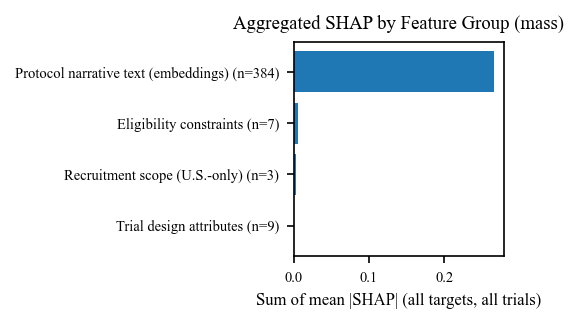

Saved: artifacts/fig_shap_group_mean_per_feature.pdf
Saved: artifacts/fig_shap_group_mean_per_feature.png


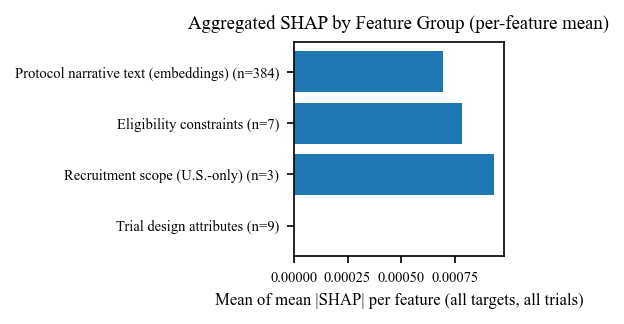

Saved: artifacts/table6_group_mass_no_embeddings.csv
Saved: artifacts/fig_shap_group_mass_no_embeddings.pdf
Saved: artifacts/fig_shap_group_mass_no_embeddings.png


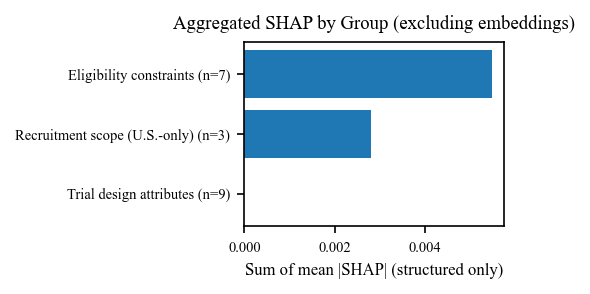

Saved: artifacts/fig_top_structured_features.pdf
Saved: artifacts/fig_top_structured_features.png


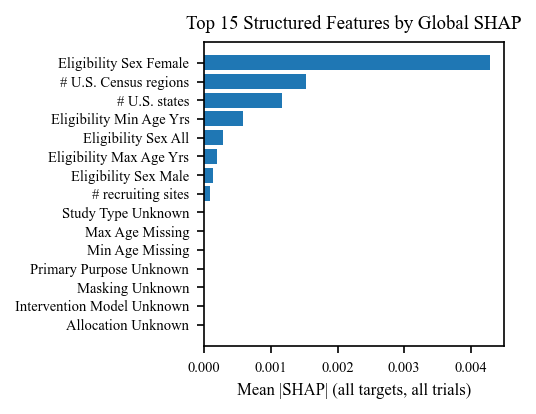

Saved: artifacts/fig_shap_group_by_target_heatmap.pdf
Saved: artifacts/fig_shap_group_by_target_heatmap.png


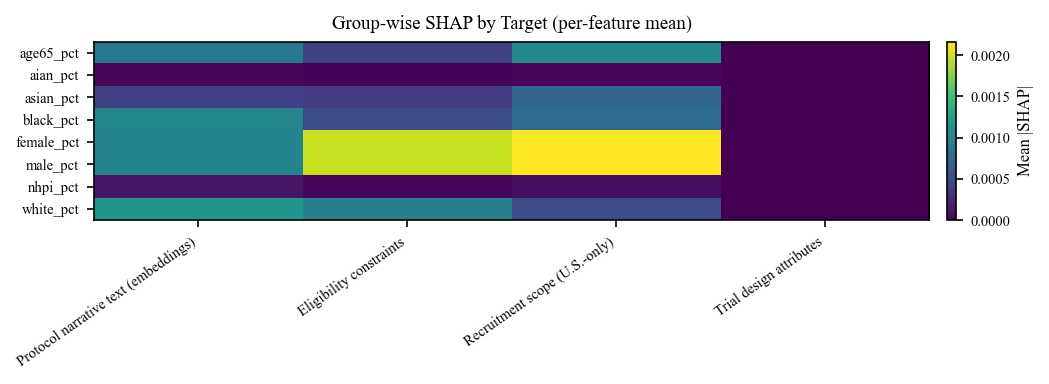


DONE. Check artifacts/ for PDFs + PNGs + CSV tables.


In [25]:
# ============================================================
# IEEE-READY SHAP EXPORT + FIGURES (CatBoost Multi-Output, Native SHAP)
# Produces:
#  - CSV tables (Table 6 variants + Table 7 variants)
#  - Vector PDFs (IEEE-friendly) + high-res PNGs
#
# REQUIRED IN NOTEBOOK:
#   cb_model_multituned (CatBoostRegressor)
#   X_train, y_train
#   FINAL_FEATURE_NAMES (list)
#   TARGET_COLS (list)
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor

# -----------------------------
# 0) Setup + Guardrails
# -----------------------------
assert "cb_model_multituned" in globals(), "Missing: cb_model_multituned (CatBoostRegressor)"
assert isinstance(cb_model_multituned, CatBoostRegressor), f"cb_model_multituned is {type(cb_model_multituned)}"
assert "X_train" in globals(), "Missing: X_train"
assert "y_train" in globals(), "Missing: y_train"
assert "FINAL_FEATURE_NAMES" in globals(), "Missing: FINAL_FEATURE_NAMES"
assert "TARGET_COLS" in globals(), "Missing: TARGET_COLS"

os.makedirs("artifacts", exist_ok=True)

# ensure column alignment if X_train is a DataFrame
try:
    X_train = X_train[FINAL_FEATURE_NAMES]
except Exception:
    pass

assert X_train.shape[1] == len(FINAL_FEATURE_NAMES), (
    f"X_train has {X_train.shape[1]} cols, FINAL_FEATURE_NAMES has {len(FINAL_FEATURE_NAMES)}"
)

# -----------------------------
# 1) IEEE plotting defaults
# -----------------------------
# IEEE single-column is ~3.5 in wide; double-column ~7.16 in wide.
IEEE_SINGLE_COL_W = 3.5
IEEE_DOUBLE_COL_W = 7.16

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "DejaVu Serif"],
    "pdf.fonttype": 42,  # embed TrueType fonts
    "ps.fonttype": 42,
})

def save_ieee(fig, base_name, single_col=True):
    """Save PDF (vector) and PNG (raster) to artifacts/ with IEEE-ish sizing."""
    w = IEEE_SINGLE_COL_W if single_col else IEEE_DOUBLE_COL_W
    # Choose height heuristically from current
    fig.set_size_inches(w, fig.get_size_inches()[1], forward=True)
    fig.tight_layout()
    pdf_path = os.path.join("artifacts", f"{base_name}.pdf")
    png_path = os.path.join("artifacts", f"{base_name}.png")
    fig.savefig(pdf_path, bbox_inches="tight")
    fig.savefig(png_path, bbox_inches="tight")
    print(f"Saved: {pdf_path}")
    print(f"Saved: {png_path}")

# -----------------------------
# 2) Compute SHAP via CatBoost native API
# -----------------------------
print("Computing CatBoost SHAP values... (can take a bit)")
train_pool = Pool(X_train, y_train)
shap_values_full = cb_model_multituned.get_feature_importance(train_pool, type="ShapValues")

# Handle shapes robustly:
# common: (n_samples, n_targets, n_features + 1)
# sometimes: (n_samples, n_features + 1) for single-target
if shap_values_full.ndim == 2:
    shap_values_full = shap_values_full[:, np.newaxis, :]  # add target axis

base_values = shap_values_full[:, :, -1]
shap_values = shap_values_full[:, :, :-1]

n_samples, n_targets, n_features = shap_values.shape
print("SHAP tensor shape:", shap_values.shape)
assert n_targets == len(TARGET_COLS), f"Targets mismatch: SHAP {n_targets} vs TARGET_COLS {len(TARGET_COLS)}"
assert n_features == len(FINAL_FEATURE_NAMES), f"Features mismatch: SHAP {n_features} vs FINAL_FEATURE_NAMES {len(FINAL_FEATURE_NAMES)}"

abs_shap = np.abs(shap_values)  # (n_samples, n_targets, n_features)

# -----------------------------
# 3) Pretty feature names
# -----------------------------
EMBED_PREFIX = "text_embed_"

def pretty_feature_name(f):
    if isinstance(f, (int, np.integer)):
        return f"{EMBED_PREFIX}{int(f)}"
    if isinstance(f, str) and f.isdigit():
        return f"{EMBED_PREFIX}{f}"

    if f in {"n_sites", "n_us_states", "n_us_regions"}:
        return {
            "n_sites": "# recruiting sites",
            "n_us_states": "# U.S. states",
            "n_us_regions": "# U.S. Census regions",
        }[f]

    if isinstance(f, str):
        return f.replace("_", " ").strip().title()
    return str(f)

pretty_names = [pretty_feature_name(f) for f in FINAL_FEATURE_NAMES]

# -----------------------------
# 4) Feature grouping (match your Methods C buckets)
# -----------------------------
def is_embedding_feat(original_name):
    if isinstance(original_name, (int, np.integer)):
        return True
    if isinstance(original_name, str) and original_name.isdigit():
        return True
    if isinstance(original_name, str) and original_name.startswith("text_embed_"):
        return True
    return False

def feature_group(original_name):
    if is_embedding_feat(original_name):
        return "Protocol narrative text (embeddings)"

    if isinstance(original_name, str):
        if original_name.startswith("eligibility_") or "age" in original_name:
            return "Eligibility constraints"
        if original_name in {"n_sites", "n_us_states", "n_us_regions"}:
            return "Recruitment scope (U.S.-only)"
        roots = (
            "phases_", "funder_type_", "study_type_", "allocation_",
            "intervention_model_", "masking_", "primary_purpose_",
            "sponsor_", "collaborators_"
        )
        if original_name.startswith(roots):
            return "Trial design attributes"

    return "Other / uncategorized"

groups = [feature_group(f) for f in FINAL_FEATURE_NAMES]
groups_s = pd.Series(groups, name="group")
group_counts = groups_s.value_counts().to_dict()
print("Group counts:", group_counts)

# -----------------------------
# 5) Global feature importance (mean |SHAP| over samples AND targets)
# -----------------------------
mean_abs_by_feature_global = abs_shap.mean(axis=(0, 1))  # (n_features,)
global_imp = (
    pd.DataFrame({"feature_raw": FINAL_FEATURE_NAMES,
                  "feature": pretty_names,
                  "group": groups,
                  "mean_abs_shap": mean_abs_by_feature_global})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)
global_imp.to_csv("artifacts/table_global_shap_by_feature.csv", index=False)
print("Saved: artifacts/table_global_shap_by_feature.csv")

# -----------------------------
# 6) TABLE 6 (two variants)
#   6A) "Mass" = sum(mean|SHAP|) within group  (what you currently do)
#   6B) "Per-feature mean" = mean(mean|SHAP|) within group (normalizes for group size)
# -----------------------------
df_feat = pd.DataFrame({
    "feature_raw": FINAL_FEATURE_NAMES,
    "feature": pretty_names,
    "group": groups,
    "mean_abs_shap": mean_abs_by_feature_global
})

table6_mass = (
    df_feat.groupby("group", as_index=False)
           .agg(mean_abs_shap_sum=("mean_abs_shap", "sum"),
                n_features=("mean_abs_shap", "count"),
                mean_abs_shap_per_feature=("mean_abs_shap", "mean"),
                median_abs_shap_per_feature=("mean_abs_shap", "median"))
           .sort_values("mean_abs_shap_sum", ascending=False)
           .reset_index(drop=True)
)

table6_mass.to_csv("artifacts/table6_group_mass_and_density.csv", index=False)
print("Saved: artifacts/table6_group_mass_and_density.csv")

# Define a consistent group order for plots/tables
ordered_groups = table6_mass["group"].tolist()

# -----------------------------
# 7) TABLE 7 (two variants) by target x group
#   7A) mass per target = sum(mean|SHAP| over features in group)
#   7B) per-feature mean per target = mean(mean|SHAP| over features in group)
# -----------------------------
rows = []
for t_idx, targ in enumerate(TARGET_COLS):
    mean_abs_by_feature_t = abs_shap[:, t_idx, :].mean(axis=0)  # (n_features,)
    tmp = pd.DataFrame({
        "target": targ,
        "group": groups,
        "mean_abs_shap": mean_abs_by_feature_t
    })
    rows.append(tmp)

df_t = pd.concat(rows, ignore_index=True)

table7_mass = (
    df_t.groupby(["target", "group"], as_index=False)["mean_abs_shap"].sum()
        .pivot(index="target", columns="group", values="mean_abs_shap")
        .fillna(0.0)
)

table7_mean = (
    df_t.groupby(["target", "group"], as_index=False)["mean_abs_shap"].mean()
        .pivot(index="target", columns="group", values="mean_abs_shap")
        .fillna(0.0)
)

# align columns
for tbl in (table7_mass, table7_mean):
    for g in ordered_groups:
        if g not in tbl.columns:
            tbl[g] = 0.0
    tbl = tbl[ordered_groups]

table7_mass = table7_mass[ordered_groups]
table7_mean = table7_mean[ordered_groups]

table7_mass.to_csv("artifacts/table7_group_mass_by_target.csv")
table7_mean.to_csv("artifacts/table7_group_mean_by_target.csv")
print("Saved: artifacts/table7_group_mass_by_target.csv")
print("Saved: artifacts/table7_group_mean_by_target.csv")

# -----------------------------
# 8) FIGURE 1: Group MASS (sum) with n_features in labels  (single column)
# -----------------------------
fig1, ax = plt.subplots(figsize=(IEEE_SINGLE_COL_W, 2.2))
y_labels = [f"{g} (n={group_counts.get(g,0)})" for g in ordered_groups]
vals = table6_mass.set_index("group").loc[ordered_groups, "mean_abs_shap_sum"].values
ax.barh(y_labels[::-1], vals[::-1])
ax.set_title("Aggregated SHAP by Feature Group (mass)")
ax.set_xlabel("Sum of mean |SHAP| (all targets, all trials)")
save_ieee(fig1, "fig_shap_group_mass", single_col=True)
plt.show()

# -----------------------------
# 9) FIGURE 2: Group PER-FEATURE mean (normalized)  (single column)
# -----------------------------
fig2, ax = plt.subplots(figsize=(IEEE_SINGLE_COL_W, 2.2))
vals2 = table6_mass.set_index("group").loc[ordered_groups, "mean_abs_shap_per_feature"].values
ax.barh(y_labels[::-1], vals2[::-1])
ax.set_title("Aggregated SHAP by Feature Group (per-feature mean)")
ax.set_xlabel("Mean of mean |SHAP| per feature (all targets, all trials)")
save_ieee(fig2, "fig_shap_group_mean_per_feature", single_col=True)
plt.show()

# -----------------------------
# 10) FIGURE 3: Group MASS excluding embeddings (helps interpret structured drivers)
# -----------------------------
df_no_embed = df_feat[~df_feat["feature_raw"].apply(is_embedding_feat)].copy()

table6_noembed_mass = (
    df_no_embed.groupby("group", as_index=False)
               .agg(mean_abs_shap_sum=("mean_abs_shap", "sum"),
                    n_features=("mean_abs_shap", "count"),
                    mean_abs_shap_per_feature=("mean_abs_shap", "mean"))
               .sort_values("mean_abs_shap_sum", ascending=False)
               .reset_index(drop=True)
)

table6_noembed_mass.to_csv("artifacts/table6_group_mass_no_embeddings.csv", index=False)
print("Saved: artifacts/table6_group_mass_no_embeddings.csv")

ordered_groups_noembed = table6_noembed_mass["group"].tolist()
y_no = [f"{g} (n={int(table6_noembed_mass.set_index('group').loc[g,'n_features'])})" for g in ordered_groups_noembed]
vals_no = table6_noembed_mass.set_index("group").loc[ordered_groups_noembed, "mean_abs_shap_sum"].values

fig3, ax = plt.subplots(figsize=(IEEE_SINGLE_COL_W, 2.0))
ax.barh(y_no[::-1], vals_no[::-1])
ax.set_title("Aggregated SHAP by Group (excluding embeddings)")
ax.set_xlabel("Sum of mean |SHAP| (structured only)")
save_ieee(fig3, "fig_shap_group_mass_no_embeddings", single_col=True)
plt.show()

# -----------------------------
# 11) FIGURE 4: Top structured (non-embedding) features (single column)
# -----------------------------
TOPK = 15
top_struct = global_imp[~global_imp["feature_raw"].apply(is_embedding_feat)].head(TOPK).iloc[::-1]

fig4, ax = plt.subplots(figsize=(IEEE_SINGLE_COL_W, 2.8))
ax.barh(top_struct["feature"], top_struct["mean_abs_shap"])
ax.set_title(f"Top {TOPK} Structured Features by Global SHAP")
ax.set_xlabel("Mean |SHAP| (all targets, all trials)")
save_ieee(fig4, "fig_top_structured_features", single_col=True)
plt.show()

# -----------------------------
# 12) FIGURE 5: Heatmap — group attribution by target (MASS or MEAN)
# Choose which you want in paper; usually use MEAN to reduce group-size bias.
# -----------------------------
use_table7 = table7_mean.copy()   # swap to table7_mass if you prefer
fig5, ax = plt.subplots(figsize=(IEEE_DOUBLE_COL_W, 2.6))  # wide figure fits better
mat = use_table7.values
im = ax.imshow(mat, aspect="auto")  # default colormap
ax.set_title("Group-wise SHAP by Target (per-feature mean)")
ax.set_yticks(np.arange(use_table7.shape[0]))
ax.set_yticklabels(use_table7.index)
ax.set_xticks(np.arange(use_table7.shape[1]))
ax.set_xticklabels(use_table7.columns, rotation=35, ha="right")

cbar = fig5.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("Mean |SHAP|")

save_ieee(fig5, "fig_shap_group_by_target_heatmap", single_col=False)
plt.show()

print("\nDONE. Check artifacts/ for PDFs + PNGs + CSV tables.")


In [32]:
# ============================================================
# 7. BUILD shap_values_by_target (REQUIRED FOR EXPORT)
# ============================================================
# Creates a clean, explicit mapping:
#   target_name → (n_samples, n_features) SHAP matrix
#
# Assumes:
#   • shap_values shape = (n_samples, n_targets, n_features)
#   • TARGET_COLS length == n_targets
#   • FINAL_FEATURE_NAMES length == n_features
# ============================================================

# ------------------------------------------------------------
# 0. Guardrails (NON-NEGOTIABLE)
# ------------------------------------------------------------
assert "shap_values" in globals(), "❌ shap_values not found"
assert shap_values.ndim == 3, "❌ shap_values must be 3D"
assert shap_values.shape[1] == len(TARGET_COLS), (
    "❌ shap_values target dimension does not match TARGET_COLS"
)
assert shap_values.shape[2] == len(FINAL_FEATURE_NAMES), (
    "❌ shap_values feature dimension does not match FINAL_FEATURE_NAMES"
)

# ------------------------------------------------------------
# 1. Build per-target SHAP dictionary
# ------------------------------------------------------------
shap_values_by_target = {
    TARGET_COLS[i]: shap_values[:, i, :]
    for i in range(len(TARGET_COLS))
}

# ------------------------------------------------------------
# 2. Sanity check
# ------------------------------------------------------------
for k, v in shap_values_by_target.items():
    assert v.shape[1] == len(FINAL_FEATURE_NAMES), (
        f"❌ Feature mismatch for target {k}"
    )

print("✅ Built shap_values_by_target for targets:")
print(list(shap_values_by_target.keys()))
print(
    "Example shape:",
    list(shap_values_by_target.values())[0].shape,
    "(n_samples, n_features)"
)



✅ Built shap_values_by_target for targets:
['white_pct', 'black_pct', 'asian_pct', 'aian_pct', 'nhpi_pct', 'male_pct', 'female_pct', 'age65_pct']
Example shape: (825, 403) (n_samples, n_features)


In [33]:
# ============================================================
# EXPORT SHAP IMPORTANCE (DASHBOARD-READY, FINAL)
# ============================================================

import json
import numpy as np
import os

def export_shap_importance(
    shap_values_by_target,
    feature_names,
    out_path,
    top_k=25,
):
    """
    Exports mean(|SHAP|) feature importance per target.

    Output schema (JSON):
    {
      "metric": "mean_abs_shap",
      "targets": {
        "white_pct": [
          {"feature": "...", "mean_abs_shap": 0.0123},
          ...
        ],
        ...
      }
    }
    """

    # ------------------------------------------------------------
    # Guardrails (NON-NEGOTIABLE)
    # ------------------------------------------------------------
    assert isinstance(shap_values_by_target, dict), "❌ shap_values_by_target must be dict"
    assert len(shap_values_by_target) > 0, "❌ shap_values_by_target is empty"

    for targ, vals in shap_values_by_target.items():
        assert vals.shape[1] == len(feature_names), (
            f"❌ Feature mismatch for {targ}: "
            f"{vals.shape[1]} SHAP features vs {len(feature_names)} names"
        )

    # ------------------------------------------------------------
    # Compute importance
    # ------------------------------------------------------------
    importance = {}

    for target, shap_vals in shap_values_by_target.items():
        mean_abs = np.abs(shap_vals).mean(axis=0)
        top_idx = np.argsort(mean_abs)[::-1][:top_k]

        importance[target] = [
            {
                "feature": feature_names[i],
                "mean_abs_shap": float(mean_abs[i]),
            }
            for i in top_idx
        ]

    payload = {
        "metric": "mean_abs_shap",
        "targets": importance,
    }

    # ------------------------------------------------------------
    # Write file safely
    # ------------------------------------------------------------
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    with open(out_path, "w") as f:
        json.dump(payload, f, indent=2)

    print(f"✅ SHAP importance exported → {out_path}")
    print(f"Targets:", list(importance.keys()))


# ============================================================
# CALL EXPORT (CANONICAL)
# ============================================================

export_shap_importance(
    shap_values_by_target=shap_values_by_target,
    feature_names=FINAL_FEATURE_NAMES,   # 🔒 CANONICAL SOURCE
    out_path="artifacts/shap_importance.json",
)



✅ SHAP importance exported → artifacts/shap_importance.json
Targets: ['white_pct', 'black_pct', 'asian_pct', 'aian_pct', 'nhpi_pct', 'male_pct', 'female_pct', 'age65_pct']


In [34]:
# ============================================================
# 18. OPTUNA HYPERPARAMETER TUNING — FAST SINGLE-TARGET VERSION
# ============================================================

import optuna
import numpy as np
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error

print("Starting Optuna tuning (super-fast mode)...")

# ------------------------------------------------------------
# 0. Reproducibility (NON-NEGOTIABLE)
# ------------------------------------------------------------
RNG = np.random.default_rng(RANDOM_STATE)

# ------------------------------------------------------------
# 1. Choose ONE representative target
# ------------------------------------------------------------
TARGET = "white_pct"
assert TARGET in TARGET_COLS, f"❌ {TARGET} not in TARGET_COLS"

y_train_single = y_train[TARGET].values
y_test_single  = y_test[TARGET].values

# ------------------------------------------------------------
# 2. Subsample validation set (FAST + CONSISTENT)
# ------------------------------------------------------------
N_VAL_OPT = max(40, int(0.15 * len(X_test)))

idx = RNG.choice(len(X_test), size=N_VAL_OPT, replace=False)

X_val_opt = X_test.iloc[idx]
y_val_opt = y_test_single[idx]

assert len(X_val_opt) == len(y_val_opt)

# ------------------------------------------------------------
# 3. CatBoost Pools
# ------------------------------------------------------------
train_pool = Pool(X_train, y_train_single)
val_pool   = Pool(X_val_opt, y_val_opt)

# ------------------------------------------------------------
# 4. Objective
# ------------------------------------------------------------
def objective(trial):

    params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",

        # Core tunables
        "iterations": trial.suggest_int("iterations", 200, 600),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.01, 0.2, log=True
        ),
        "l2_leaf_reg": trial.suggest_float(
            "l2_leaf_reg", 1.0, 10.0
        ),

        # Stability / reproducibility
        "random_seed": RANDOM_STATE,
        "task_type": "CPU",
        "early_stopping_rounds": 30,
        "verbose": False,
    }

    model = CatBoostRegressor(**params)

    model.fit(
        train_pool,
        eval_set=val_pool,
        verbose=False,
    )

    preds = model.predict(X_val_opt)
    rmse = mean_squared_error(y_val_opt, preds, squared=False)

    return rmse

# ------------------------------------------------------------
# 5. Run optimization
# ------------------------------------------------------------
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
)

study.optimize(objective, n_trials=25, show_progress_bar=True)

# ------------------------------------------------------------
# 6. Results
# ------------------------------------------------------------
print("\n✅ Best RMSE:", study.best_value)
print("Best parameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")




[I 2025-12-23 15:37:54,292] A new study created in memory with name: no-name-2cff0f6e-c039-4bc1-925a-67cbf2f5ec0a


Starting Optuna tuning (super-fast mode)...


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:37:59,429] Trial 0 finished with value: 0.28707994525215413 and parameters: {'iterations': 350, 'depth': 8, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 6.387926357773329}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:00,423] Trial 1 finished with value: 0.29986137762429105 and parameters: {'iterations': 262, 'depth': 4, 'learning_rate': 0.011900590783184251, 'l2_leaf_reg': 8.795585311974417}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:17,642] Trial 2 finished with value: 0.29182658282605173 and parameters: {'iterations': 441, 'depth': 7, 'learning_rate': 0.010636066512540286, 'l2_leaf_reg': 9.72918866945795}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:20,299] Trial 3 finished with value: 0.29308918594290634 and parameters: {'iterations': 533, 'depth': 5, 'learning_rate': 0.017240892195821537, 'l2_leaf_reg': 2.650640588680904}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:23,733] Trial 4 finished with value: 0.29460926134605425 and parameters: {'iterations': 322, 'depth': 6, 'learning_rate': 0.03647316284911211, 'l2_leaf_reg': 3.6210622617823773}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:24,827] Trial 5 finished with value: 0.295925539578736 and parameters: {'iterations': 445, 'depth': 4, 'learning_rate': 0.023993242906812727, 'l2_leaf_reg': 4.297256589643226}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:26,204] Trial 6 finished with value: 0.3038515245833089 and parameters: {'iterations': 382, 'depth': 7, 'learning_rate': 0.018187859051288217, 'l2_leaf_reg': 5.628109945722504}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:26,593] Trial 7 finished with value: 0.2999893070363916 and parameters: {'iterations': 437, 'depth': 4, 'learning_rate': 0.061721159481070736, 'l2_leaf_reg': 2.5347171131856236}. Best is trial 0 with value: 0.28707994525215413.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:33,312] Trial 8 finished with value: 0.2838183131797331 and parameters: {'iterations': 226, 'depth': 8, 'learning_rate': 0.18043311207136256, 'l2_leaf_reg': 8.275576133048151}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:34,253] Trial 9 finished with value: 0.2941453097968735 and parameters: {'iterations': 322, 'depth': 4, 'learning_rate': 0.07766184280392888, 'l2_leaf_reg': 4.961372443656412}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:39,837] Trial 10 finished with value: 0.288688422032068 and parameters: {'iterations': 208, 'depth': 8, 'learning_rate': 0.18255631599020647, 'l2_leaf_reg': 7.386758617430664}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:45,304] Trial 11 finished with value: 0.2897923566253941 and parameters: {'iterations': 212, 'depth': 8, 'learning_rate': 0.17760048882430093, 'l2_leaf_reg': 7.101318914492574}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:47,819] Trial 12 finished with value: 0.2962467039115362 and parameters: {'iterations': 315, 'depth': 7, 'learning_rate': 0.11144579299000193, 'l2_leaf_reg': 6.906533007950971}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:55,046] Trial 13 finished with value: 0.29095724513333504 and parameters: {'iterations': 520, 'depth': 8, 'learning_rate': 0.11050292222716614, 'l2_leaf_reg': 8.17868021662461}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:38:57,127] Trial 14 finished with value: 0.2882732504376841 and parameters: {'iterations': 264, 'depth': 6, 'learning_rate': 0.11750339105581913, 'l2_leaf_reg': 5.9682361606796706}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:08,243] Trial 15 finished with value: 0.2911474924976474 and parameters: {'iterations': 376, 'depth': 8, 'learning_rate': 0.05250393540989585, 'l2_leaf_reg': 9.297055603589946}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:10,045] Trial 16 finished with value: 0.3003592131119075 and parameters: {'iterations': 245, 'depth': 7, 'learning_rate': 0.08646863803644622, 'l2_leaf_reg': 6.38998669323469}. Best is trial 8 with value: 0.2838183131797331.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:15,459] Trial 17 finished with value: 0.2765353742010701 and parameters: {'iterations': 587, 'depth': 8, 'learning_rate': 0.19961837193620582, 'l2_leaf_reg': 8.135905304526384}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:16,413] Trial 18 finished with value: 0.291975581218826 and parameters: {'iterations': 568, 'depth': 6, 'learning_rate': 0.19853034153514587, 'l2_leaf_reg': 8.176551859491767}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:19,005] Trial 19 finished with value: 0.2930116648006079 and parameters: {'iterations': 591, 'depth': 7, 'learning_rate': 0.14168403504983026, 'l2_leaf_reg': 9.96415290425092}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:21,957] Trial 20 finished with value: 0.28873441925726545 and parameters: {'iterations': 499, 'depth': 5, 'learning_rate': 0.03468935799273658, 'l2_leaf_reg': 8.109691196781995}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:27,099] Trial 21 finished with value: 0.29138941009100977 and parameters: {'iterations': 362, 'depth': 8, 'learning_rate': 0.14402763178017153, 'l2_leaf_reg': 7.724755307291936}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:35,285] Trial 22 finished with value: 0.28681480815914195 and parameters: {'iterations': 297, 'depth': 8, 'learning_rate': 0.08561319703535926, 'l2_leaf_reg': 8.887420845884183}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:44,558] Trial 23 finished with value: 0.280841867501892 and parameters: {'iterations': 289, 'depth': 8, 'learning_rate': 0.1464768927282256, 'l2_leaf_reg': 1.1882220983506357}. Best is trial 17 with value: 0.2765353742010701.


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[I 2025-12-23 15:39:45,937] Trial 24 finished with value: 0.30067918604091054 and parameters: {'iterations': 229, 'depth': 7, 'learning_rate': 0.1464962498526511, 'l2_leaf_reg': 2.004586600780884}. Best is trial 17 with value: 0.2765353742010701.

✅ Best RMSE: 0.2765353742010701
Best parameters:
  iterations: 587
  depth: 8
  learning_rate: 0.19961837193620582
  l2_leaf_reg: 8.135905304526384


In [35]:
# ============================================================
# 9. FINAL CATBOOST TRAINING — MULTI-TARGET (OPTUNA-INFORMED)
# ============================================================

from catboost import Pool, CatBoostRegressor

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_test,  y_test)

cb_model = CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",

    # Optuna-informed, stability-biased parameters
    iterations=600,
    depth=8,
    learning_rate=0.10,
    l2_leaf_reg=5.0,

    # Stability
    random_seed=RANDOM_STATE,
    task_type="CPU",
    early_stopping_rounds=80,

    verbose=100,
)

cb_model.fit(
    train_pool,
    eval_set=val_pool,
)

print("✅ Final CatBoost multi-target model trained (Optuna-informed)")





0:	learn: 0.5863591	test: 0.5869631	best: 0.5869631 (0)	total: 617ms	remaining: 6m 9s
100:	learn: 0.2899784	test: 0.5614948	best: 0.5612782 (67)	total: 1m 7s	remaining: 5m 33s
200:	learn: 0.1605490	test: 0.5589087	best: 0.5582206 (156)	total: 2m 12s	remaining: 4m 22s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.5582206203
bestIteration = 156

Shrink model to first 157 iterations.
✅ Final CatBoost multi-target model trained (Optuna-informed)


In [36]:
print("=== BASELINE MODEL (cb_model, deployment-faithful) ===")

def predict_with_hurdles(model, X):
    """
    Matches predictor.py behavior:
    - base multi-target prediction
    - hurdle correction for sparse targets
    - sex normalization
    """
    preds = model.predict(X)

    # Ensure 2D
    if preds.ndim == 1:
        preds = preds.reshape(-1, len(TARGET_COLS))

    preds = np.clip(preds, 0, 1)

    # ---- Apply hurdle models ----
    for j, target in enumerate(TARGET_COLS):
        if target in hurdle_clf:
            clf = hurdle_clf[target]
            reg = hurdle_reg[target]

            p_pos = clf.predict_proba(X)[:, 1]

            if reg is not None:
                r = reg.predict(X)
            else:
                r = np.zeros(len(X))

            preds[:, j] = np.clip(p_pos * r, 0, 1)

    # ---- Sex normalization ----
    male_idx   = TARGET_COLS.index("male_pct")
    female_idx = TARGET_COLS.index("female_pct")

    denom = preds[:, male_idx] + preds[:, female_idx] + 1e-8
    preds[:, male_idx]   /= denom
    preds[:, female_idx] /= denom

    return np.clip(preds, 0, 1)


# ---- Generate baseline predictions ----
baseline_preds = predict_with_hurdles(cb_model, X_test)

# ---- Compute mean RMSE across all targets ----
baseline_rmse = np.mean([
    mean_squared_error(
        y_test[TARGET_COLS[i]].values,
        baseline_preds[:, i],
        squared=False
    )
    for i in range(len(TARGET_COLS))
])

print(f"Baseline Multi-target RMSE: {baseline_rmse:.4f}")




=== BASELINE MODEL (cb_model, deployment-faithful) ===
Baseline Multi-target RMSE: 0.1818


/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/abigailtubbs/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be re

In [37]:
# ============================================================
# DEPLOYMENT / REPRODUCIBILITY CHECK — LOAD SAVED ARTIFACTS
# (NOT USED FOR TRAINING OR EVALUATION)
# ============================================================


import os
import joblib
from catboost import CatBoostRegressor

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
BASE_DIR = "/Users/abigailtubbs/Downloads/digital_twin"
MODEL_DIR = os.path.join(BASE_DIR, "model")

MODEL_PATH         = os.path.join(MODEL_DIR, "cb_model_multituned.cbm")
ENCODER_PATH       = os.path.join(MODEL_DIR, "encoder.pkl")
CAT_COLS_PATH      = os.path.join(MODEL_DIR, "CAT_COLS.pkl")
NUM_COLS_PATH      = os.path.join(MODEL_DIR, "NUM_COLS.pkl")
TARGET_COLS_PATH   = os.path.join(MODEL_DIR, "TARGET_COLS.pkl")
FEATURE_NAMES_PATH = os.path.join(MODEL_DIR, "FEATURE_NAMES.pkl")
HURDLE_CLF_PATH    = os.path.join(MODEL_DIR, "hurdle_clf.pkl")
HURDLE_REG_PATH    = os.path.join(MODEL_DIR, "hurdle_reg.pkl")
SCHEMA_PATH        = os.path.join(MODEL_DIR, "schema_manifest.pkl")

# ------------------------------------------------------------
# 1. Load core model
# ------------------------------------------------------------
model_loaded = CatBoostRegressor()
model_loaded.load_model(MODEL_PATH)


# ------------------------------------------------------------
# 2. Load encoders + metadata
# ------------------------------------------------------------
encoder             = joblib.load(ENCODER_PATH)
CAT_COLS            = joblib.load(CAT_COLS_PATH)
NUM_COLS            = joblib.load(NUM_COLS_PATH)
TARGET_COLS         = joblib.load(TARGET_COLS_PATH)
FINAL_FEATURE_NAMES = joblib.load(FEATURE_NAMES_PATH)

schema_manifest = joblib.load(SCHEMA_PATH) if os.path.exists(SCHEMA_PATH) else None

# ------------------------------------------------------------
# 3. Load hurdle models
# ------------------------------------------------------------
hurdle_clf = joblib.load(HURDLE_CLF_PATH)
hurdle_reg = joblib.load(HURDLE_REG_PATH)

# ------------------------------------------------------------
# 4. HARD VALIDATION (FAIL FAST)
# ------------------------------------------------------------
FORBIDDEN_GEO_CATS = {"country", "continent", "us_region"}
assert FORBIDDEN_GEO_CATS.isdisjoint(CAT_COLS), (
    f"❌ Geographic categorical columns detected in CAT_COLS: "
    f"{FORBIDDEN_GEO_CATS.intersection(CAT_COLS)}"
)

REQUIRED_GEO_NUMS = {"n_sites", "n_us_states", "n_us_regions"}
assert REQUIRED_GEO_NUMS.issubset(set(NUM_COLS)), (
    f"❌ Missing required geographic numeric features.\n"
    f"Expected: {REQUIRED_GEO_NUMS}\n"
    f"Found: {set(NUM_COLS)}"
)

if schema_manifest:
    expected_features = (
        schema_manifest["embedding_dim"]
        + len(CAT_COLS)
        + len(NUM_COLS)
    )
    assert len(FINAL_FEATURE_NAMES) == expected_features, (
        "❌ FEATURE_NAMES length mismatch.\n"
        f"Expected: {expected_features}\n"
        f"Found: {len(FINAL_FEATURE_NAMES)}"
    )

    assert schema_manifest.get("us_only_trials", False) is True, (
        "❌ Loaded model expects U.S.-only trials, but schema_manifest disagrees."
    )

assert set(hurdle_clf.keys()).issubset(set(TARGET_COLS)), (
    "❌ Hurdle models found for targets not in TARGET_COLS."
)

# ------------------------------------------------------------
# 5. Confirmation
# ------------------------------------------------------------
print("✔ Models loaded successfully")
print("Targets:", TARGET_COLS)
print("Rare targets with hurdle models:", list(hurdle_clf.keys()))

if schema_manifest:
    print("✔ Schema manifest loaded")
    print("  - Embedding dim:", schema_manifest["embedding_dim"])
    print("  - Geo numeric cols:", schema_manifest["geo_numeric_cols"])




✔ Models loaded successfully
Targets: ['white_pct', 'black_pct', 'asian_pct', 'aian_pct', 'nhpi_pct', 'male_pct', 'female_pct', 'age65_pct']
Rare targets with hurdle models: ['aian_pct', 'nhpi_pct', 'asian_pct']
